In [81]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [88]:
#Workspace set-up - data loading, figure directory configuration, final processing of dataset (these steps now 
#done earlier in workflow to subset to cecal contents and remove prevotella species)

DATASET = "rlog"

PARAM_STR = "thr3_prev0.3_cecal_nonprevotella"
transformed_data_path = "formatted_output/transformed/{0}".format(PARAM_STR)
figures_dir = "figures/{0}/SVD_{1}".format(PARAM_STR,DATASET)
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)



bpm_filt_data_path = "formatted_output/bpm_filtered/{0}".format(PARAM_STR) 
bpm_filt_expr_fpath = "{0}/bpm_filt_{1}.csv".format(bpm_filt_data_path,DATASET)
pht_agg_expr_fpath = "{0}/bpm1_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)
condensed_agg_expr_fpath = "{0}/condensed_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)

bpm_filt_expr_df = pd.read_csv(bpm_filt_expr_fpath,index_col=0)
pht_agg_expr_df = pd.read_csv(pht_agg_expr_fpath,index_col=0)
condensed_agg_expr_df = pd.read_csv(condensed_agg_expr_fpath,index_col=0)
print("Pre-filtering:")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)

#Cecal contents only filtering 
cecal_filter = True 
if cecal_filter:
    cecal_bpm_filt_expr_df = bpm_filt_expr_df.loc[:,bpm_filt_expr_df.columns.str.contains("cecal")]
    bpm_filt_expr_df = cecal_bpm_filt_expr_df
    
    cecal_condensed_agg_df = condensed_agg_expr_df.loc[:,condensed_agg_expr_df.columns.str.contains("cecal")]
    condensed_agg_expr_df = cecal_condensed_agg_df

drop_prevotella = True 
if drop_prevotella:
    bpm_filt_expr_df = bpm_filt_expr_df.loc[~bpm_filt_expr_df.index.str.contains(r'NBCBLOMG|NJCFFJJN'),:]
    condensed_agg_expr_df = condensed_agg_expr_df.loc[~condensed_agg_expr_df.index.str.contains(r'Pst|Pco'),:]


feature_center = True
if feature_center:
    bpm_filt_expr_df = bpm_filt_expr_df.subtract(bpm_filt_expr_df.mean(axis=1),axis=0)
    condensed_agg_expr_df = condensed_agg_expr_df.subtract(condensed_agg_expr_df.mean(axis=1),axis=0)
    
assert(np.isclose(bpm_filt_expr_df.mean(axis=1).sum(),0))
assert(np.isclose(condensed_agg_expr_df.mean(axis=1).sum(),0))

#Convert so that samples are rows, features are columns (ie tranpose of previous data format)
data_tranpose = True 
if data_tranpose:
    if not bpm_filt_expr_df.index.str.contains("cecal").sum():
        bpm_filt_expr_df = bpm_filt_expr_df.transpose()
    if not condensed_agg_expr_df.index.str.contains("cecal").sum():
        condensed_agg_expr_df = condensed_agg_expr_df.transpose()
print("Post Filtering/Transpose")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)
        
        
# print("==BPM=1 Transcripts STD==")        
# display(bpm_filt_expr_df.std(axis=0))
# print("==BPM=1 Phenotypes STD==")        
# display(condensed_agg_expr_df.std(axis=0))

Pre-filtering:


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2A_Pup_1,Pup_2.cecal_contents_54_2A_Pup_2,Pup_3.cecal_contents_54_2A_Pup_3,Pup_4.cecal_contents_54_2A_Pup_4,Pup_5.cecal_contents_54_2A_Pup_5,Pup_6.cecal_contents_54_2A_Pup_6,Pup_7.cecal_contents_54_2A_Pup_7
ANCJAENF_00439,8.929374,7.008538,9.404771,10.127274,9.308347,9.390687,8.795463,8.136793,-2.059151,8.470594,-1.905340,-1.980806,6.565324,-0.825449,0.890791
ANCJAENF_00597,7.423116,4.579489,8.040242,8.642906,7.937350,7.549573,7.329959,6.584036,-2.748548,5.467701,-0.398265,-2.662764,4.620343,-2.769171,0.408147
ANCJAENF_01803,7.887151,6.232775,9.184795,9.730630,8.698707,9.829451,8.055294,8.041347,-2.122164,9.950155,-1.967400,-0.125138,8.615745,-2.141091,-2.470332
ANCJAENF_01805,11.379360,9.366547,11.721933,12.624403,11.932071,12.680045,12.794093,7.272443,-1.570465,7.275901,-1.425509,0.214337,5.997430,-1.588114,-0.831938
ANCJAENF_01808,10.939061,9.341659,11.529519,12.806283,11.905360,12.888747,12.695204,6.768201,-1.705362,7.038763,-1.557693,-1.630198,5.160980,-1.723375,-2.034900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,8.333560,8.244404,9.127600,9.339353,8.009672,8.152662,8.208317,9.715779,5.108469,10.185245,7.302952,6.586882,9.319267,7.965745,8.149132
LDOIJNDB_00521,12.649843,13.563524,13.935528,15.278821,13.406638,14.342880,13.788604,14.412001,8.748234,14.733494,10.869795,10.405307,13.736230,11.897554,12.158974
LDOIJNDB_00521,12.649843,13.563524,13.935528,15.278821,13.406638,14.342880,13.788604,14.412001,8.748234,14.733494,10.869795,10.405307,13.736230,11.897554,12.158974
LDOIJNDB_01036,6.695754,7.618519,7.665413,8.305285,7.059328,7.745500,7.689250,8.517526,2.334152,8.932429,4.673165,4.181754,6.938110,5.398214,5.702148


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2A_Pup_1,Pup_2.cecal_contents_54_2A_Pup_2,Pup_3.cecal_contents_54_2A_Pup_3,Pup_4.cecal_contents_54_2A_Pup_4,Pup_5.cecal_contents_54_2A_Pup_5,Pup_6.cecal_contents_54_2A_Pup_6,Pup_7.cecal_contents_54_2A_Pup_7
Bbr_Glc,8.176245,5.794013,8.722507,9.385090,8.622849,8.470130,8.062711,7.360414,-2.403849,6.969148,-1.151802,-2.321785,5.592834,-1.797310,0.649469
Bbr_NANA,10.929539,9.009234,11.373317,12.408855,11.585509,12.516768,12.232378,6.623051,-1.587658,7.281532,-1.437048,-1.184355,5.779717,-1.606031,-1.791342
Bbr_Fuc,10.603107,8.231109,10.865599,12.153446,11.339090,12.087353,10.586391,9.743233,-1.235039,11.207772,2.783150,0.795114,9.083371,1.198530,3.593328
Bbr_Mal,10.244975,7.301996,10.562663,11.536088,10.672798,11.152488,10.158866,10.955354,-0.569863,11.089124,0.267404,-0.514348,7.783701,-0.238813,-0.398057
Bbr_Lnb,9.169883,5.377960,9.549066,9.755200,9.153521,9.405056,8.542212,8.364026,-0.940826,8.839255,1.021035,-1.019570,8.688752,1.724493,2.547293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spa_Acetate,9.388147,8.972203,10.161745,9.141597,8.851228,8.043602,9.779885,11.013404,5.203432,10.033164,7.386679,6.731901,9.324878,7.847417,8.192117
Spa_Formate,9.867620,10.280021,11.157702,10.564119,9.951988,9.787307,10.639712,12.065745,5.814084,12.236458,7.781980,7.548026,10.496272,8.503286,8.705432
Spa_L-Lactate,8.333560,8.244404,9.127600,9.339353,8.009672,8.152662,8.208317,9.715779,5.108469,10.185245,7.302952,6.586882,9.319267,7.965745,8.149132
Spa_Ethanol,10.665147,11.581856,11.845490,12.954309,11.290868,12.143753,11.755486,12.447176,6.610207,12.799806,8.804252,8.330789,11.470190,9.731107,10.006699


Post Filtering/Transpose


,ANCJAENF_00439,ANCJAENF_00597,ANCJAENF_01803,ANCJAENF_01805,ANCJAENF_01808,ANCJAENF_01809,ANCJAENF_01810,ANCJAENF_01810,ANCJAENF_01811,ANCJAENF_01812,...,LDOIJNDB_01767,LDOIJNDB_00635,LDOIJNDB_02060,LDOIJNDB_01022,LDOIJNDB_01273,LDOIJNDB_01949,LDOIJNDB_00521,LDOIJNDB_00521,LDOIJNDB_01036,LDOIJNDB_00003
Pup_1.cecal_contents_53_1C_Pup_1,3.578893,3.422841,2.727156,4.856524,4.777578,4.949323,5.377814,5.377814,5.227932,5.004320,...,0.460517,0.419812,1.013629,-0.069439,0.418046,0.083624,-0.278652,-0.278652,0.065317,0.050307
Pup_2.cecal_contents_53_1C_Pup_2,1.658057,0.579215,1.072780,2.843711,3.180176,3.163176,3.439001,3.439001,3.040529,2.757651,...,-0.845166,0.451409,0.150144,0.805605,0.367803,-0.005532,0.635029,0.635029,0.988082,0.735367
Pup_3.cecal_contents_53_1C_Pup_3,4.054290,4.039968,4.024800,5.199097,5.368036,5.200236,5.624516,5.624516,5.464483,5.343005,...,1.603787,1.465970,1.514668,1.321882,1.606888,0.877664,1.007033,1.007033,1.034977,1.794762
Pup_4.cecal_contents_53_1C_Pup_4,4.776793,4.642631,4.570635,6.101568,6.644800,6.216018,6.795287,6.795287,6.586857,6.422539,...,-0.691165,1.006273,-0.065932,1.295507,0.446097,1.089417,2.350326,2.350326,1.674849,1.940501
Pup_5.cecal_contents_53_1C_Pup_5,3.957866,3.937076,3.538712,5.409235,5.743877,5.508272,5.966381,5.966381,5.738704,5.674666,...,0.595989,0.333873,0.025730,0.132656,0.384687,-0.240264,0.478143,0.478143,0.428891,0.233918
Pup_6.cecal_contents_53_1C_Pup_6,4.040207,3.549298,4.669456,6.157209,6.727264,6.330627,6.733781,6.733781,6.516715,7.127465,...,-0.767368,-0.117861,-1.137789,0.626833,-0.438852,-0.097274,1.414385,1.414385,1.115063,0.989929
Pup_7.cecal_contents_53_1C_Pup_7,3.444982,3.329685,2.895299,6.271258,6.533721,6.254554,6.729233,6.729233,6.565625,6.742254,...,0.780114,1.210177,1.006741,0.880210,1.012581,-0.041619,0.860109,0.860109,1.058814,1.221091
Pup_8.cecal_contents_53_1C_Pup_8,2.786312,2.583762,2.881352,0.749607,0.606718,0.156713,-0.177020,-0.177020,-0.286169,0.092377,...,2.150171,2.511741,2.172215,2.304885,2.439972,1.465843,1.483506,1.483506,1.887090,2.298511
Pup_1.cecal_contents_54_2A_Pup_1,-7.409631,-6.748822,-7.282159,-8.093300,-7.866845,-7.443936,-8.041927,-8.041927,-7.514744,-7.554272,...,-3.095294,-3.885960,-3.050029,-3.900066,-3.858399,-3.141467,-4.180261,-4.180261,-4.296285,-4.306588
Pup_2.cecal_contents_54_2A_Pup_2,3.120114,1.467426,4.790160,0.753065,0.877280,0.293717,0.659045,0.659045,0.280905,0.801191,...,1.367012,1.623314,1.100161,3.029310,2.056973,1.935309,1.804999,1.804999,2.301993,2.679708


,Bbr_Glc,Bbr_NANA,Bbr_Fuc,Bbr_Mal,Bbr_Lnb,Bbr_All,Bbr_Mel,Bbr_GOS,Bbr_Leu,Bbr_Ile,...,Spa_Pro,Spa_Gln,Spa_Asp,Spa_B3,Spa_B9,Spa_Acetate,Spa_Formate,Spa_L-Lactate,Spa_Ethanol,Spa_CA_d
Pup_1.cecal_contents_53_1C_Pup_1,3.500867,4.787308,3.067404,3.578017,3.158059,2.678864,3.463698,3.149523,3.613177,4.012634,...,0.710200,0.632117,0.372249,0.772334,0.460517,0.716720,0.174304,0.083624,-0.163996,0.050307
Pup_2.cecal_contents_53_1C_Pup_2,1.118636,2.867003,0.695406,0.635038,-0.633864,2.644979,-1.159908,1.159365,1.351201,0.657674,...,0.526669,0.331501,0.639265,-0.580302,-0.845166,0.300777,0.586704,-0.005532,0.752713,0.735367
Pup_3.cecal_contents_53_1C_Pup_3,4.047129,5.231086,3.329895,3.895705,3.537242,4.072107,3.246592,3.290336,4.045884,4.466290,...,1.442910,1.104062,1.253009,1.931182,1.603787,1.490319,1.464385,0.877664,1.016348,1.794762
Pup_4.cecal_contents_53_1C_Pup_4,4.709712,6.266624,4.617743,4.869130,3.743377,3.841285,3.334517,4.459485,4.453178,5.027467,...,0.290819,1.569792,1.410760,-0.482001,-0.691165,0.470170,0.870802,1.089417,2.125167,1.940501
Pup_5.cecal_contents_53_1C_Pup_5,3.947471,5.443278,3.803386,4.005840,3.141697,2.714290,3.904604,3.284399,3.812544,3.810644,...,0.492541,0.097191,0.368184,0.434785,0.595989,0.179801,0.258671,-0.240264,0.461726,0.233918
Pup_6.cecal_contents_53_1C_Pup_6,3.794752,6.374537,4.551649,4.485529,3.393233,6.734841,2.404451,3.821187,3.943441,3.785742,...,0.289405,0.314941,0.513683,-2.227283,-0.767368,-0.627825,0.093990,-0.097274,1.314611,0.989929
Pup_7.cecal_contents_53_1C_Pup_7,3.387333,6.090147,3.050687,3.491908,2.530389,2.486300,1.490263,2.249371,2.977752,3.099660,...,1.284133,0.699243,1.028705,0.570097,0.780114,1.108459,0.946395,-0.041619,0.926344,1.221091
Pup_8.cecal_contents_53_1C_Pup_8,2.685037,0.480820,2.207530,4.288396,2.352202,2.963641,2.063906,2.545333,2.985156,2.358005,...,2.219834,2.251789,2.575492,2.131593,2.150171,2.341978,2.372428,1.465843,1.618034,2.298511
Pup_1.cecal_contents_54_2A_Pup_1,-7.079227,-7.729889,-8.770743,-7.236822,-6.952650,-7.013410,-7.109966,-7.145739,-7.924521,-7.297747,...,-4.466170,-3.958108,-4.356881,-3.813559,-3.095294,-3.467995,-3.879233,-3.141467,-4.218936,-4.306588
Pup_2.cecal_contents_54_2A_Pup_2,2.293770,1.139301,3.672069,4.422165,2.827431,1.212233,5.599872,4.758178,3.132319,2.535070,...,1.759251,1.420100,1.705350,2.018895,1.367012,1.361737,2.543141,1.935309,1.970663,2.679708


From np.linalag.svd:
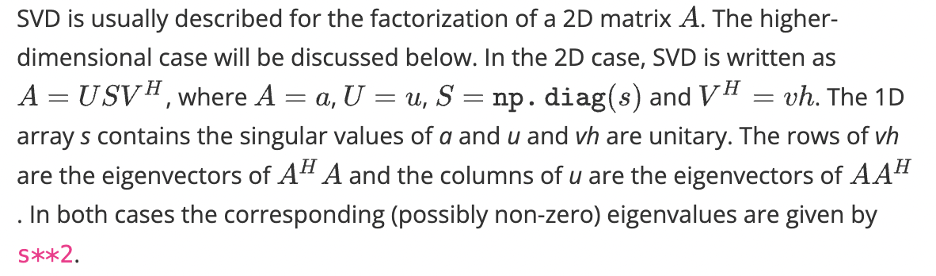

In [117]:
def sv_projections(feature_df,u,s,vh,pc_indices=[0,1],axis=0):
    """Return projections of feature_df onto singular vectors specified by axis 
        feature_df: samples (index) x features (columns)
        u: Matrix of left singular vectors (columns) - n_samples x n_samples
        s: singular values (vector) 
        vh: Matrix of right singular vectors (columns) - n_features x n_features
        pc_indices: list-like of indicies for which singular vectors to generate projections on  
        axis: 0 or 1, for generating sample projections or feature projections respectively 
    """
    #Generate PCs, a len(pc_indices) x {n_samples or n_features} ndarray representing the PCs specified 
    #by pc_indices and axis
    if axis == 0: #sample projections 
        SVs = vh[pc_indices,:]# n_PCs x n_features 
        data = feature_df.values.transpose() #n_features x n_samples
        assert(SVs.shape[1] == data.shape[0])
    elif axis == 1: #feature projections
        SVs = u[:,pc_indices].transpose() #n_PCs x n_samples
        data = feature_df.values #n_samples x n_features 
        assert(SVs.shape[1] == data.shape[0])
    else: 
        raise ValueError("axis must be 0 (sample projections) or 1 (feature projections)")
    #projections = PCs * data
    projections = np.dot(SVs,data)
    return projections
    
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def sig_str_from_pval(pval):
    if pval < 0.0001: 
        sig_str = "****"
    elif pval < 0.001: 
        sig_str = "***"
    elif pval < 0.01: 
        sig_str = "**"
    elif pval < 0.05: 
        sig_str = "*"
    else:
        sig_str = "ns"
    return sig_str

def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title("LSV Projections of strain phenotypes by strain",weight="bold",fontsize=title_size)

Permanova p-value: 0.000580
Permanova p-value: 0.000460


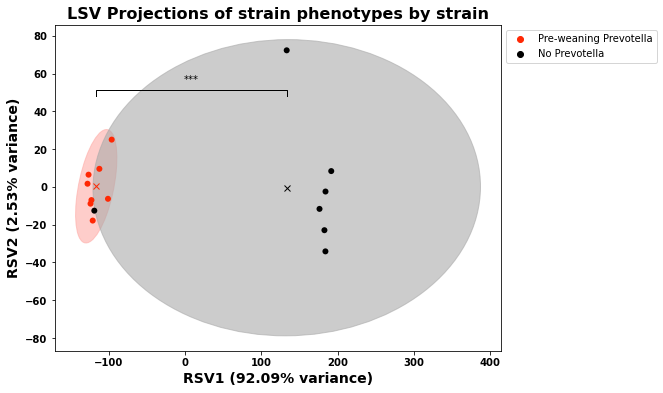

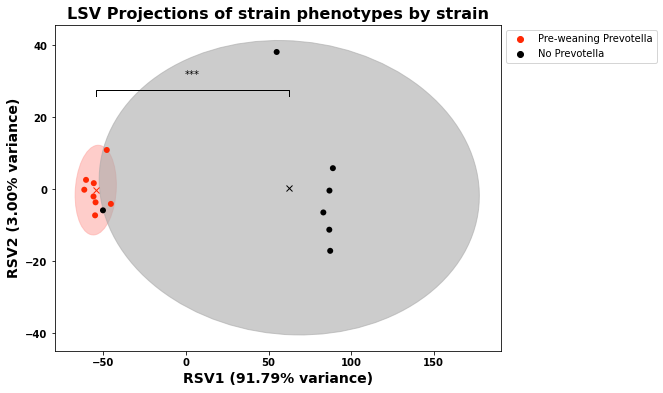

In [118]:
def sample_projections_scatter(expr_df, pc_indices,sample_arm_re=r'[\w_]+\.[\w_]+_([12][AC])_[\w+]',title_str="",
                              figure_fpath="",arm_labels=["Pre-weaning Prevotella","No Prevotella"]): 
    #Palettes 
    HWDC_points_palette = ["#FF2804","#000000"]
    HWDC_ellipses_palette = ["#FEACA7","#AAAAAA"]
    
    #SVD, explained variance calculations 
    u,s,vh = svd(expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    
    #Sample projections
    pc_indices = [0,1]
    sample_projections = sv_projections(expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = expr_df.index.str.extract(sample_arm_re)
    
    
    v1 = sample_projections.T #M vectors in K dimensions = n_samples x n_PCs
    #permanova requires a skbio.stats.distance.DistanceMatrix object, must convert output  
    sp_dm = sk_distance.DistanceMatrix(distance_matrix(v1,v1,p=2))

    skpa = sk_distance.permanova(distance_matrix=sp_dm,grouping=sample_proj_df["Arm"],permutations=100000)
    skpa_p = skpa["p-value"]
    sig_str = sig_str_from_pval(skpa_p)
    print("Permanova p-value: {:.6f}".format(skpa_p))
    #Scatter plot of sampel projections using 
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    point_palette=HWDC_points_palette
    ellipses_palette = HWDC_ellipses_palette
    sns.scatterplot(data=sample_proj_df,x="RSV1",y="RSV2",hue="Arm",palette=point_palette,zorder=1,linewidth=0)
    
    #Get sample projections subsetted by arm (1C vs 2A), as well as cluster centers for arm
    sample_proj_1C = sample_proj_df.loc[sample_proj_df["Arm"] == "1C",:]
    center_1C_x, center_1C_y = np.mean(sample_proj_1C["RSV1"]),np.mean(sample_proj_1C["RSV2"])
    sample_proj_2A  = sample_proj_df.loc[sample_proj_df["Arm"] == "2A",:]
    center_2A_x, center_2A_y = np.mean(sample_proj_2A["RSV1"]),np.mean(sample_proj_2A["RSV2"])
    #Cluster center markers 
    ax.plot(center_1C_x,center_1C_y,c=point_palette[0],marker='x')
    ax.plot(center_2A_x,center_2A_y,c=point_palette[1],marker='x')
    #Confidence ellipses around each cluster - TODO: adjust n_std to correspond to 95% confidence in 2D (1D equiv of .975)
    ellipse1_c, ellipse2_c = ellipses_palette
    confidence_ellipse(x=sample_proj_1C["RSV1"],y=sample_proj_1C["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse1_c,facecolor=ellipse1_c,alpha=0.6,zorder=0)
    confidence_ellipse(x=sample_proj_2A["RSV1"],y=sample_proj_2A["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse2_c,facecolor=ellipse2_c,alpha=0.6,zorder=0)
    #Pyplot Formatting - axis and tick labels, title
    xlabel = "RSV{0} ({1}% variance)".format(pc_indices[0]+1,"%.2f" % (expl_variance[pc_indices[0]]*100))
    ylabel = "RSV{0} ({1}% variance)".format(pc_indices[1]+1,"%.2f" % (expl_variance[pc_indices[1]]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_labels=arm_labels)
    #Significance bracket: x1, x2 = cluster centers (x); y2 = bar y position, y1 = bracket extent 
    x1, x2 = center_1C_x, center_2A_x
    ymin, ymax = ax.get_ylim()
    y2 = ymax - (ymax-ymin)*.2
    y1 = y2-(ymax-ymin)*.02
    plt.text((x1+x2)*.5, y2+3, sig_str, ha='center', va='bottom', color='k')
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    if figure_fpath:
        plt.savefig(figure_fpath, dpi=300, facecolor='w',bbox_inches="tight",format="pdf")

pc_indices = [0,1]
title_str = "BPM=1 Transcript RSV Sample Projections"
figure_fpath = "{0}/bpm1_transcripts_SVD.pdf".format(figures_dir)
sample_projections_scatter(bpm_filt_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)


pc_indices = [0,1]
title_str = "BPM=1 Phenotype RSV Sample Projections"
figure_fpath = "{0}/bpm1_condensed_pht_SVD.pdf".format(figures_dir)
sample_projections_scatter(condensed_agg_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)

In [119]:
#Load mcseed_df for strain and phenotype annotations of feature projections 
formatted_dir = "formatted_input"
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)

mcseed_df = pd.read_csv(mcseed_path)
mcseed_df.set_index("Locus tag",inplace=True)
mcseed_list_phts = mcseed_df.copy()
for col in ["Functional category","Functional pathway", "Phenotype"]:
    mcseed_list_phts.loc[:,col] = mcseed_list_phts.loc[:,col].str.split(";")
display(mcseed_df)
display(mcseed_list_phts)
strains = mcseed_df["Isolate name"].unique()

#STRAIN_TAGS maps full strain names to abbreviations 
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(strains,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, strains))



,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac


,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",[Carbohydrate utilization],"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",[Carbohydrate utilization],"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",[Carbohydrate utilization],"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),[Carbohydrate utilization],"[galactose utilization, lactose utilization]","[Gal, Lac]"
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),[Carbohydrate utilization],"[galactose utilization, lactose utilization]","[Gal, Lac]"
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",[Carbohydrate utilization],[trehalose utilization],[Tre]
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",[Carbohydrate utilization],[trehalose utilization],[Tre]
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),[Carbohydrate utilization],"[galactose utilization, lactose utilization]","[Gal, Lac]"


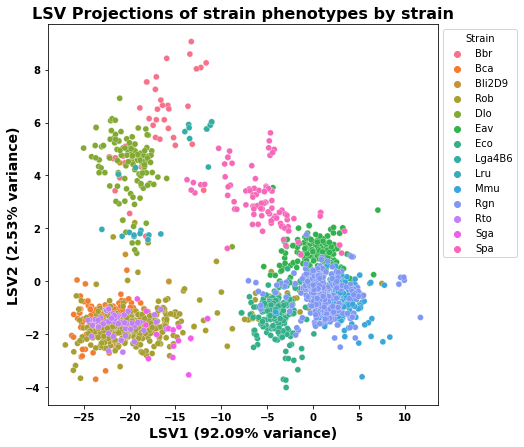

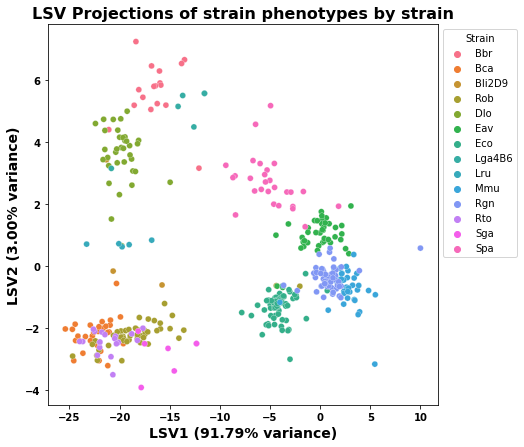

In [126]:
def LSV_feature_projections(expr_df,pc_indices,mcseed_df,feature_type="transcript",title_str="",fig_fpath=""):
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    
    strain_palette = sns.color_palette("husl", len(fp_tr_mcseed["Isolate name"].unique()))
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index].drop_duplicates()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
        #[STRAIN_TAGS[l] for l in labels]
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_pht_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_pht_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    #Solo phenotype LSV Plot
    
    sns.scatterplot(data=fp_df_mcseed,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain")
    
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
        
title_str = "LSV Projections of transcripts by strain"
fig_fpath = "{0}/LSV_transcript_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(bpm_filt_expr_df,pc_indices,mcseed_df,feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath)

title_str = "LSV Projections of phenotypes by strain"
fig_fpath = "{0}/LSV_phenotype_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(condensed_agg_expr_df,pc_indices,mcseed_df,feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath)
        


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ANCJAENF_00439,-17.091144,6.102984,Bifidobacterium breve Bgsng463_m5_93,GlcK,Glucokinase (EC 2.7.1.2),Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00597,-15.017800,5.137741,Bifidobacterium breve Bgsng463_m5_93,PpgK,Polyphosphate glucokinase (EC 2.7.1.63),Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_01803,-17.189176,7.252283,Bifidobacterium breve Bgsng463_m5_93,NanR_bif,Transcriptional regulator of sialic acid metab...,Carbohydrate utilization,N-acetylneuraminate utilization,NANA,Bbr
ANCJAENF_01805,-20.703628,4.734067,Bifidobacterium breve Bgsng463_m5_93,NanH1,"Exo-alpha-(2-3/2-6)-sialidase, GH33",Carbohydrate utilization,N-acetylneuraminate utilization,NANA,Bbr
ANCJAENF_01808,-21.805610,4.639518,Bifidobacterium breve Bgsng463_m5_93,NanA,N-acetylneuraminate lyase (EC 4.1.3.3),Carbohydrate utilization,N-acetylneuraminate utilization,NANA,Bbr
...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,-2.850905,2.492472,Streptococcus pasteriuanus Bang_SAM2_39_S1,LdhA-L,L-lactate dehydrogenase (EC 1.1.1.27),Fermentation products,L-lactate production,L-Lactate,Spa
LDOIJNDB_00521,-5.316014,3.392958,Streptococcus pasteriuanus Bang_SAM2_39_S1,AADH,Acetaldehyde dehydrogenase (EC 1.2.1.10),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_00521,-5.316014,3.392958,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_01036,-5.698971,2.749678,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa


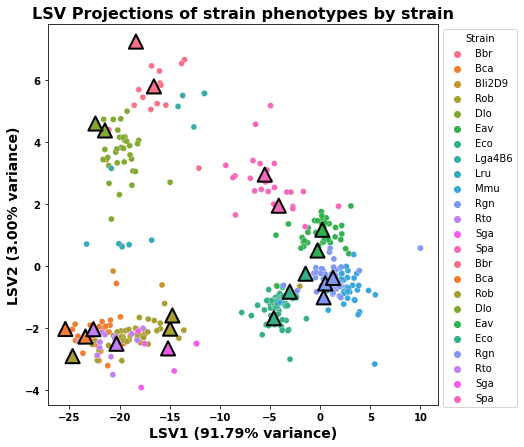

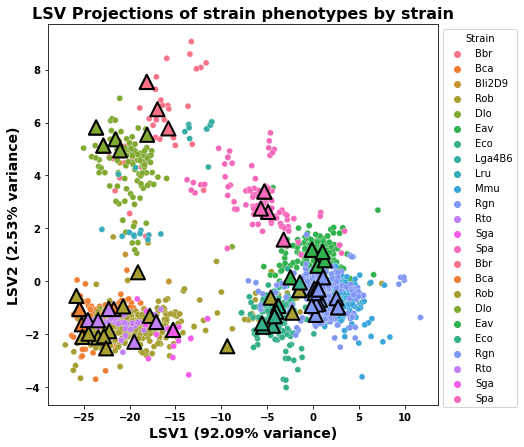

In [158]:
def LSV_feature_projections_partition(expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                                      feature_type="transcript",title_str="",fig_fpath=""):
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index].drop_duplicates()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
        display(fp_df_mcseed)
        #[STRAIN_TAGS[l] for l in labels]
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    #Solo phenotype LSV Plot
    
    match_pattern = 
    
    
    partition_match = fp_df_mcseed.loc[fp_df_mcseed[partition_col].isin(partition_values)]
    partition_rest = fp_df_mcseed.loc[~fp_df_mcseed[partition_col].isin(partition_values)]
    strain_palette = sns.color_palette("husl", len(fp_tr_mcseed["Isolate name"].unique()))
    strain_palette = dict(zip(fp_df_mcseed["Strain abbreviation"].unique(),strain_palette))
    
    
    sns.scatterplot(data=partition_rest,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    sns.scatterplot(data=partition_match,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",marker="^",edgecolor="#000000",
                    linewidth=2,s=200)
                    #markers={'linewidths':2,'marker':"^","markersize":20,'edgecolors':"#000000"})#linewidth=0.5,marker="^",edgecolor='b')
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain")
    
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
    return fig, fp_df_mcseed
        
title_str = "LSV Projections of phenotypes, Propionate/Acetate Fermentation"
fig_fpath = "{0}/pht_LSV_.pdf".format(figures_dir)
partition_col = "Phenotype"
partition_values = ["Propionate","Acetate","Ethanol"]
fig, fp_df_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath)

partition_col = "Phenotype"
partition_values = ["Propionate","Acetate","Ethanol"]
fig, fp_df_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath)

In [148]:
display(fp_df_mcseed[fp_df_mcseed["LSV1"]>4])

,LSV1,LSV2,Strain abbreviation,Phenotype
Mmu_Lac,5.452680,-3.153203,Mmu,Lac
Mmu_Bgl,4.830483,-0.785723,Mmu,Bgl
Mmu_B1,5.507337,-0.921056,Mmu,B1
Rgn_Lac,10.000964,0.580007,Rgn,Lac


,LSV1,LSV2,Strain abbreviation,Phenotype,Functional category
Bbr_Glc,-16.249224,5.229909,Bbr,Glc,Carbohydrate utilization
Bbr_NANA,-21.078317,4.392373,Bbr,NANA,Carbohydrate utilization
Bbr_Fuc,-16.024760,6.279535,Bbr,Fuc,Carbohydrate utilization
Bbr_Mal,-18.547027,5.177793,Bbr,Mal,Carbohydrate utilization
Bbr_Lnb,-13.527036,6.642449,Bbr,Lnb,Carbohydrate utilization
...,...,...,...,...,...
Spa_Acetate,-4.126614,1.944897,Spa,Acetate,Fermentation products
Spa_Formate,-5.175076,2.403415,Spa,Formate,Fermentation products
Spa_L-Lactate,-2.914485,2.382116,Spa,L-Lactate,Fermentation products
Spa_Ethanol,-5.526498,2.945796,Spa,Ethanol,Fermentation products


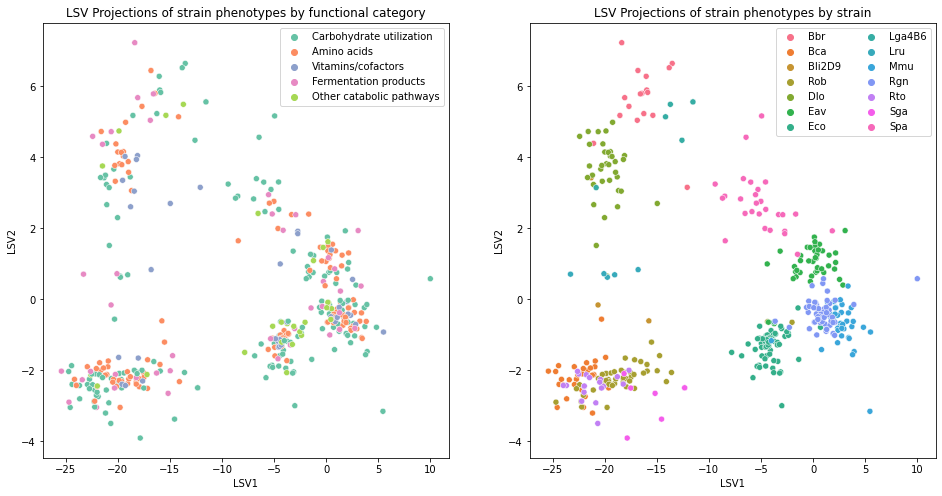

In [47]:
#Mapping pathways back to functional categories 
#Use mcseed_df (without list version phenotypes) for list of phenotype unique values 
pht_fc_dict = {}
for pht_str in mcseed_df["Phenotype"].unique(): #pht_str is a variable length semicolon separated string of different phenotypes
    pht_list = pht_str.split(";") 
    pht_str_rows = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str,:]
    assert(len(pht_str_rows["Functional category"].unique()) == 1)
    fc_cat_str = pht_str_rows["Functional category"].iloc[0]
    fc_cat_list = fc_cat_str.split(";")
    for i,pht in enumerate(pht_list):
        if pht not in pht_fc_dict:
            if len(fc_cat_list) == 1: #If only one functional category for all entries in pht_str, use that category
                pht_fc_dict[pht] = fc_cat_list[0]
            elif len(fc_cat_list) == len(pht_list): #If one-to-one mapping of phenotypes to functional categories, go in order
                pht_fc_dict[pht] = fc_cat_list[i]
            else: #Not one-to-one mapping of phenotypes to functional categories; use some HARD CODING TM  
                print(pht_str)
                print(fc_cat_str)
                raise ValueError("Cannot automatically match phenotypes to functional categories based on prior entries")

fp_pht_mcseed.loc[:,"Functional category"] = fp_pht_mcseed["Phenotype"].map(pht_fc_dict)
display(fp_pht_mcseed)

n_fc_unique = len(fp_pht_mcseed["Functional category"].unique())
# fc_palette = sns.color_palette("husl", n_fc_unique)
fc_palette = sns.color_palette("Set2")[:n_fc_unique]
fig,axes = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = axes
#Strain phenotypes by functional category
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax1,
                palette=fc_palette,hue="Functional category")
handles,labels = ax1.get_legend_handles_labels()
ax1.legend(handles,labels,loc="best")
ax1.set_title("LSV Projections of strain phenotypes by functional category")
#Strain phenotypes by strain
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax2,
                palette=strain_palette,hue="Strain abbreviation")
handles,labels = ax2.get_legend_handles_labels()
ax2.legend(handles,labels,loc="best",ncol=2)
ax2.set_title("LSV Projections of strain phenotypes by strain")
plt.savefig("{0}/feature_projections_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

plt.savefig("{0}/phenotypes_functionalcategory_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")


,LSV1,LSV2,Strain abbreviation,Phenotype
Mmu_Lac,5.452680,-3.153203,Mmu,Lac
Mmu_Bgl,4.830483,-0.785723,Mmu,Bgl
Mmu_B1,5.507337,-0.921056,Mmu,B1
Rgn_Lac,10.000964,0.580007,Rgn,Lac


Explained Variance (Transcripts, first 2): [0.91698847 0.0246164 ]
Explained Variance (Phenotype, first 2): [0.91401062 0.0296341 ]
LSV1 Transcript
[-0.21971702 -0.18010869 -0.23042857 -0.22791743 -0.22379315 -0.16755403
 -0.22121045 -0.20107081  0.32923792 -0.21619382  0.32060288  0.32765006
  0.24546969  0.32741202  0.3376214 ]
RSV1 Transcript
[-0.032243   -0.02960579 -0.03222824 ... -0.00923872 -0.01107412
 -0.01177655]
-0.03910159277758576 0.005037890520870739
-0.08112407537559266 0.00819325039552663


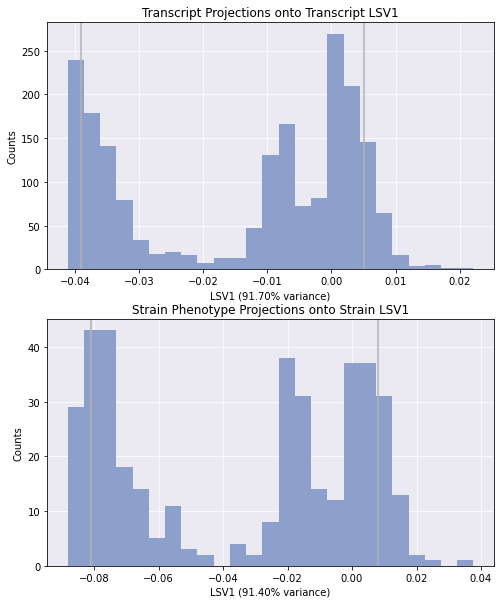

In [15]:
#SVD Feature Comparison 
u_tr,s_tr,vh_tr = svd(bpm_filt_log_df)
u_pht,s_pht,vh_pht = svd(condensed_agg_log_df,full_matrices=True)

#Explained variance calculated from s -> eigenvalues 
eigenvalues_tr = s_tr**2/(len(s_tr)-1)
expl_variance_tr = eigenvalues_tr / np.sum(eigenvalues_tr)
eigenvalues_pht = s_pht**2/(len(s_pht)-1)
expl_variance_pht = eigenvalues_pht / np.sum(eigenvalues_pht)

n_SV = 2
print("Explained Variance (Transcripts, first {0}): {1}".format(n_SV,expl_variance_tr[:n_SV]))
print("Explained Variance (Phenotype, first {0}): {1}".format(n_SV,expl_variance_pht[:n_SV]))

LSV1_tr = u_tr[:,0]
RSV1_tr = vh_tr[0,:]

print("LSV1 Transcript")
print(LSV1_tr)
print("RSV1 Transcript")
print(RSV1_tr)

LSV1_pht = u_pht[:,0]
RSV1_pht = vh_pht[0,:]

tr_10th, tr_90th = np.percentile(RSV1_tr,[10,90])
print(tr_10th,tr_90th)
pht_10th, pht_90th = np.percentile(RSV1_pht,[10,90])
print(pht_10th,pht_90th)
hist_color = sns.color_palette("Set2")[2]
vline_color = sns.color_palette("Set2")[7]
#Subplots and axes set up, grids, titles, x_labels with PC
fig,axes = plt.subplots(2,1,figsize=(8,10))
ax1,ax2 = axes
for ax in [ax1,ax2]:
    ax.grid(visible=True,color="white")
    ax.set_axisbelow(True)
    ax.set_facecolor("#EBEAF2")
    ax.set_ylabel("Counts")
ax1.set_title("Transcript Projections onto Transcript LSV1")
ax1.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_tr[pc_indices[0]]*100)))
ax2.set_title("Strain Phenotype Projections onto Strain LSV1")
ax2.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_pht[pc_indices[0]]*100)))
#Histogram and vline plotting for histogram 10th and 90th percentiles 
ax1.hist(RSV1_tr.flatten(),bins=25,color=hist_color)
ax1_ylim = ax1.get_ylim()
ax1.vlines([tr_10th,tr_90th],*ax1.get_ylim(),color=vline_color,linewidth=1.5)
ax1.set_ylim(ax1_ylim) #without this line vlines resets ylims for some reason - specific to using hist 
ax2.hist(RSV1_pht.flatten(),bins=25,color=hist_color)
ax2_ylim = ax2.get_ylim()
ax2.vlines([pht_10th,pht_90th],*ax2.get_ylim(),color=vline_color,linewidth=1.5)
ax2.set_ylim(ax2_ylim)

plt.savefig("{0}/LSV1_projection_histogram.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

In [16]:
#Test cell - comparing s*SV (ie singular value weighted SVs) for PERMANOVA 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 
###Phenotypes###
u_pht,s_pht,vh_pht = svd(condensed_agg_log_df,full_matrices=True)
pc_indices = [0,1]
sample_projections = sv_projections(condensed_agg_log_df,u_pht,s_pht,vh_pht,pc_indices=pc_indices)
s_PCs = s_pht[pc_indices]
scaled_projections = np.dot(np.diag(s_PCs),sample_projections) #nPCs x n_samples

v1 = sample_projections.T #M vectors in K dimensions = n_samples x n_PCs
v2 = scaled_projections.T #n_samples x n_PCs
#permanova requires a skbio.stats.distance.DistanceMatrix object, must convert output  
sp_dm = sk_distance.DistanceMatrix(distance_matrix(v1,v1,p=2))
skpa = sk_distance.permanova(distance_matrix=sp_dm,grouping=sample_proj_df["arm"],permutations=100000)
display(skpa)

sp_dm_scaled = sk_distance.DistanceMatrix(distance_matrix(v2,v2,p=2))
skpa_scaled = sk_distance.permanova(distance_matrix=sp_dm_scaled,grouping=sample_proj_df["arm"],permutations=100000)
display(skpa_scaled)
###Transcripts###

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      15
number of groups                  2
test statistic            36.818696
p-value                     0.00043
number of permutations       100000
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      15
number of groups                  2
test statistic            41.670432
p-value                     0.00045
number of permutations       100000
Name: PERMANOVA results, dtype: object

In [ ]:
#HOSVD using log transformed transcript data, phenotype aggregated